In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

In [33]:
analysis_path = Path('../data/json/')

In [34]:
combined_df = []
for file in analysis_path.iterdir():
    df = pd.read_json(file, lines=True)
    combined_df.append(df)
combined_df = pd.concat(combined_df)
combined_df.to_json('../data/combined.json', orient='records', lines=True)

### Analysis

In [35]:
combined_df = pd.read_json('../data/combined_annotations.json', lines=True)

In [36]:
len(combined_df)

421450

In [37]:
combined_df.columns

Index(['text-topic', 'text-topic-exp', 'text-entity-name',
       'text-entity-gender', 'text-entity-sentiment',
       'text-entity-sentiment-exp', 'text-generic-frame',
       'text-generic-frame-exp', 'text-issue-frame', 'text-issue-frame-exp',
       'uuid', 'title', 'img-generic-frame', 'img-frame-exp',
       'img-entity-name', 'img-entity-gender', 'img-entity-sentiment',
       'img-entity-sentiment-exp', 'image-url', 'gpt_topic'],
      dtype='object')

In [ ]:
combined_df[combined_df['gpt_topic']=='no_topic'].to_csv("../data/no_topic.csv", index=True)

In [38]:
combined_topic_df = combined_df[combined_df['gpt_topic']!='no_topic']

In [39]:
combined_topic_df['text-frame-len'] = combined_topic_df['text-generic-frame'].apply(lambda x: len(x))
combined_topic_df['img-frame-len'] = combined_topic_df['img-generic-frame'].apply(lambda x: len(x))

/var/folders/f3/w3__06_538v99t9b747x6qgr0000gn/T/ipykernel_67763/3005157915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_topic_df['text-frame-len'] = combined_topic_df['text-generic-frame'].apply(lambda x: len(x))
/var/folders/f3/w3__06_538v99t9b747x6qgr0000gn/T/ipykernel_67763/3005157915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_topic_df['img-frame-len'] = combined_topic_df['img-generic-frame'].apply(lambda x: len(x))


In [40]:
combined_topic_df = combined_topic_df[combined_topic_df['text-frame-len']>0]
combined_topic_df = combined_topic_df[combined_topic_df['img-frame-len']>0]

In [41]:
combined_topic_df = combined_topic_df[combined_topic_df['text-frame-len']<5]

In [42]:
len(combined_topic_df)

191390

In [43]:
combined_topic_df.to_csv(analysis_path.parent/'combined_annotations_filtered.csv')
combined_topic_df.to_json(analysis_path.parent/'combined_annotations_filtered.json', orient='records', lines=True)

In [44]:
combined_topic_df['text-frame-len'].mean(), combined_topic_df['img-frame-len'].mean()

(2.731595172161555, 1.3096086524896808)

In [45]:
frame_short_dict = {'economic': 'economic',
 'capacity and resources': 'cap&res',
 'morality': 'morality',
 'fairness and equality': 'fairness',
 'legality, constitutionality and jurisprudence': 'legality',
 'policy prescription and evaluation': 'policy',
 'crime and punishment': 'crime',
 'security and defense': 'security',
 'health and safety': 'health',
 'quality of life': 'quality_life',
 'cultural identity': 'culture',
 'public opinion': 'public_op',
 'political': 'political',
 'external regulation and reputation': 'regulation',
 'other': 'other'}

In [46]:
valid_frames = frame_short_dict.values()

In [150]:
combined_topic_df['text-generic-frame']

Index(['text-topic', 'text-topic-exp', 'text-entity-name',
       'text-entity-gender', 'text-entity-sentiment',
       'text-entity-sentiment-exp', 'text-generic-frame',
       'text-generic-frame-exp', 'text-issue-frame', 'text-issue-frame-exp',
       'uuid', 'title', 'img-generic-frame', 'img-frame-exp',
       'img-entity-name', 'img-entity-gender', 'img-entity-sentiment',
       'img-entity-sentiment-exp', 'image-url', 'gpt_topic', 'text-frame-len',
       'img-frame-len'],
      dtype='object')

### Per topic

In [94]:
top_topic_list = list(combined_topic_df['gpt_topic'].value_counts()[:20].keys())
top_topic_df = combined_topic_df[combined_topic_df['gpt_topic'].isin(top_topic_list)]

In [95]:
sns.set(style="whitegrid")
sns.set_color_codes("dark")

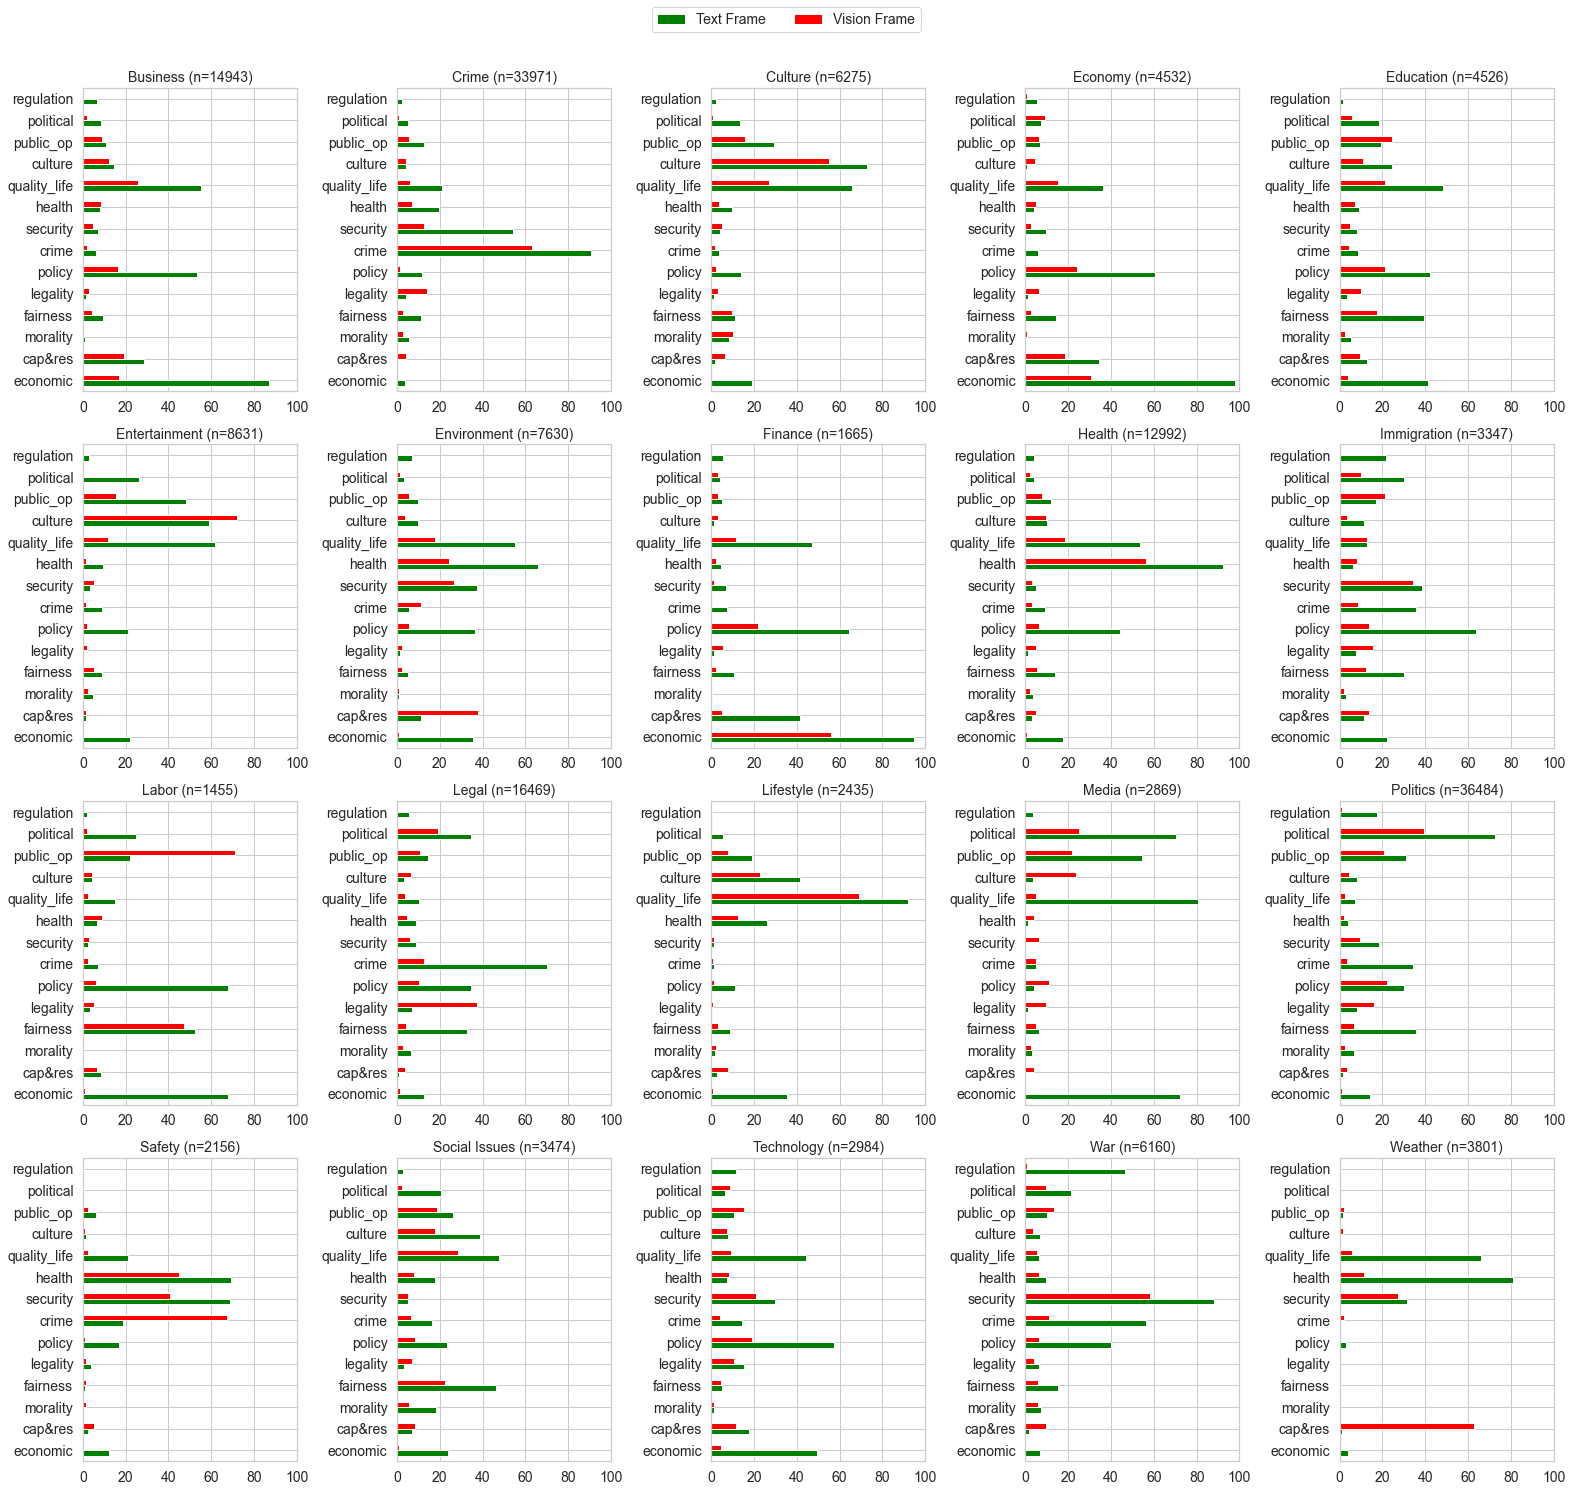

In [97]:
# top_topic_df = combined_topic_df[combined_topic_df['gpt_topic'].isin(top_topic_list)]
# Grouped bar plot for each topic
fig, ax = plt.subplots(figsize=(22,20))
plt.xticks([])
plt.yticks([])
i = 1
topic_frame_counts = []
for group_name, group in top_topic_df.groupby('gpt_topic'):
    text_frame_counter = {f:0.0 for f in valid_frames}
    vision_frame_counter = {f:0.0 for f in valid_frames}
    for index, row in group.iterrows():
        for frame_pred in row['text-generic-frame']:
            text_frame_counter[frame_pred] += 1/len(group)
        for frame_pred in row['img-generic-frame']:
            vision_frame_counter[frame_pred] += 1/len(group)
    text_frame_counter_df = pd.DataFrame.from_dict(text_frame_counter, orient='index').reset_index()
    text_frame_counter_df.columns = ['Frame', 'Text_Frame_Count']
    vision_frame_counter_df = pd.DataFrame.from_dict(vision_frame_counter, orient='index').reset_index()
    vision_frame_counter_df.columns = ['Frame', 'Image_Frame_Count']
    frame_counter_df = pd.merge(text_frame_counter_df, vision_frame_counter_df, on='Frame', how='outer')
    ax = plt.subplot(4,5,i)
    i+=1
    plt.title(group_name+' (n='+str(len(group))+')', fontsize=14)
    frame_counter_df.set_index('Frame', inplace=True)
    frame_counter_df = frame_counter_df.loc[frame_counter_df.index[:-1]]
    frame_counter_df = frame_counter_df*100
    ax.set_xlim([0, 100])
    frame_counter_df.plot(kind='barh', ax=ax, legend=False, xlabel='', ylabel='', fontsize=14, color=['green', 'red'])
    frame_counter_df.columns = [group_name+' Text Frame', group_name+' Vision Frame']
    topic_frame_counts.append(frame_counter_df)
plt.tight_layout()
handles, _ = ax.get_legend_handles_labels()
fig.legend(handles, ['Text Frame', 'Vision Frame'], loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=2, fontsize=14)
plt.savefig("../data/figures/top_20_topic_frame_distribution.png", bbox_inches='tight', dpi=300)
plt.show()

In [98]:
sel_topic_list = ['Environment', 'Immigration', 'Labor', 'War', 'Education']
selected_topic_df = combined_topic_df[combined_topic_df['gpt_topic'].isin(sel_topic_list)]

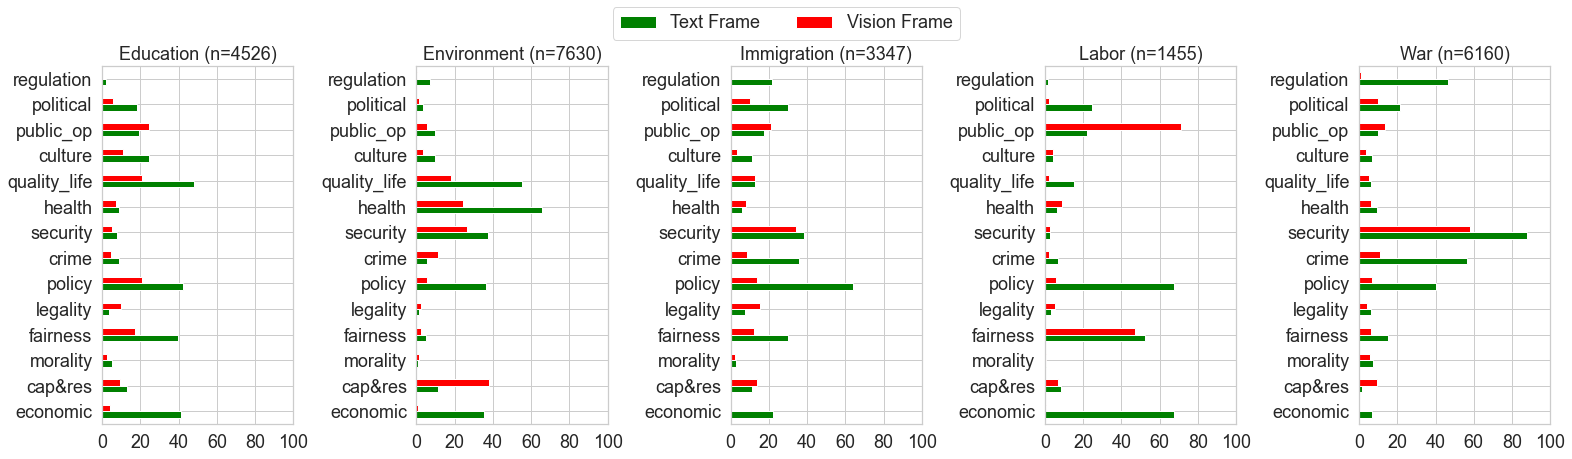

In [ ]:
# Percentage difference in frequency grouped bar plot for selected topics

fig, ax = plt.subplots(figsize=(22,6))
plt.xticks([])
plt.yticks([])
i = 1
topic_frame_counts = []
for group_name, group in selected_topic_df.groupby('gpt_topic'):
    text_frame_counter = {f:0.0 for f in valid_frames}
    vision_frame_counter = {f:0.0 for f in valid_frames}
    for index, row in group.iterrows():
        for frame_pred in row['text-generic-frame']:
            text_frame_counter[frame_pred] += 1/len(group)
        for frame_pred in row['img-generic-frame']:
            vision_frame_counter[frame_pred] += 1/len(group)
    text_frame_counter_df = pd.DataFrame.from_dict(text_frame_counter, orient='index').reset_index()
    text_frame_counter_df.columns = ['Frame', 'Text_Frame_Count']
    vision_frame_counter_df = pd.DataFrame.from_dict(vision_frame_counter, orient='index').reset_index()
    vision_frame_counter_df.columns = ['Frame', 'Image_Frame_Count']
    frame_counter_df = pd.merge(text_frame_counter_df, vision_frame_counter_df, on='Frame', how='outer')
    ax = plt.subplot(1,5,i)
    i+=1
    plt.title(group_name+' (n='+str(len(group))+')', fontsize=18)
    frame_counter_df.set_index('Frame', inplace=True)
    frame_counter_df = frame_counter_df.loc[frame_counter_df.index[:-1]]
    frame_counter_df = frame_counter_df*100
    ax.set_xlim([0, 100])
    frame_counter_df.plot(kind='barh', ax=ax, legend=False, xlabel='', ylabel='', fontsize=18, color=['green', 'red'])
    frame_counter_df.columns = [group_name+' Text Frame', group_name+' Vision Frame']
    topic_frame_counts.append(frame_counter_df)
plt.tight_layout()
handles, _ = ax.get_legend_handles_labels()
fig.legend(handles, ['Text Frame', 'Vision Frame'], loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, fontsize=18)
plt.savefig("../data/figures/selected_topic_frame_distribution.png", bbox_inches='tight', dpi=300)
plt.show()

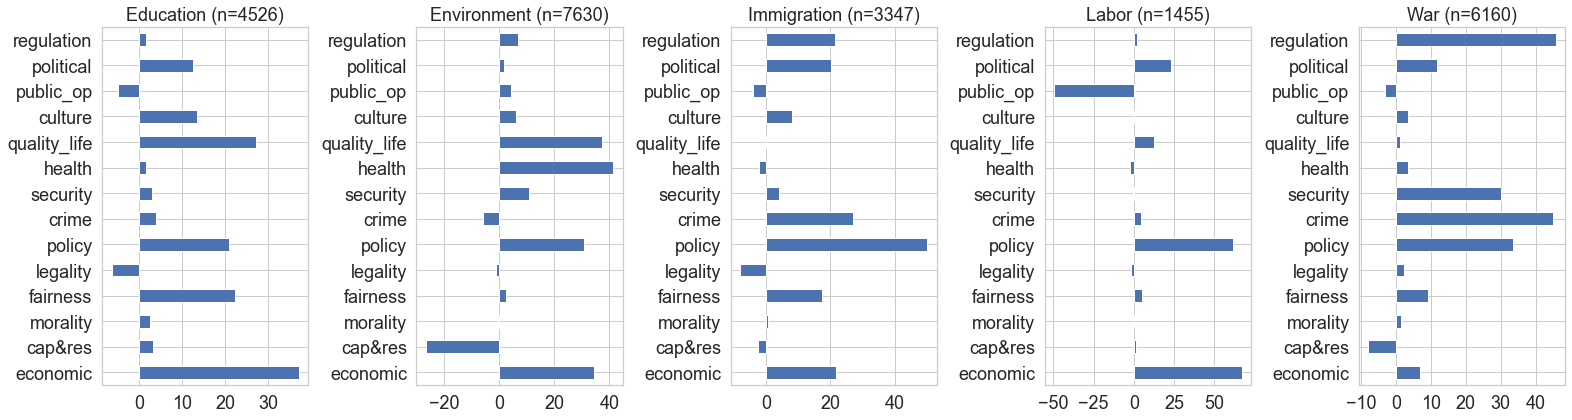

In [149]:
# Percentage difference plot for selected topics

# Grouped bar plot for each topic
fig, ax = plt.subplots(figsize=(22,6))
plt.xticks([])
plt.yticks([])
i = 1
topic_frame_counts = []
for group_name, group in selected_topic_df.groupby('gpt_topic'):
    text_frame_counter = {f:0.0 for f in valid_frames}
    vision_frame_counter = {f:0.0 for f in valid_frames}
    for index, row in group.iterrows():
        for frame_pred in row['text-generic-frame']:
            text_frame_counter[frame_pred] += 1/len(group)
        for frame_pred in row['img-generic-frame']:
            vision_frame_counter[frame_pred] += 1/len(group)
    text_frame_counter_df = pd.DataFrame.from_dict(text_frame_counter, orient='index').reset_index()
    text_frame_counter_df.columns = ['Frame', 'Text_Frame_Count']
    vision_frame_counter_df = pd.DataFrame.from_dict(vision_frame_counter, orient='index').reset_index()
    vision_frame_counter_df.columns = ['Frame', 'Image_Frame_Count']
    frame_counter_df = pd.merge(text_frame_counter_df, vision_frame_counter_df, on='Frame', how='outer')
    ax = plt.subplot(1,5,i)
    i+=1
    plt.title(group_name+' (n='+str(len(group))+')', fontsize=18)
    frame_counter_df.set_index('Frame', inplace=True)
    frame_counter_df = frame_counter_df.loc[frame_counter_df.index[:-1]]
    frame_counter_df = frame_counter_df*100
    frame_rank = frame_counter_df['Text_Frame_Count'] - frame_counter_df['Image_Frame_Count']
    frame_rank.plot(kind='barh', ax=ax, legend=False, xlabel='', ylabel='', fontsize=18)
    topic_frame_counts.append(frame_counter_df)
plt.tight_layout()
# handles, _ = ax.get_legend_handles_labels()
# fig.legend(handles, ['Text Frame', 'Vision Frame'], loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2, fontsize=18)
plt.show()

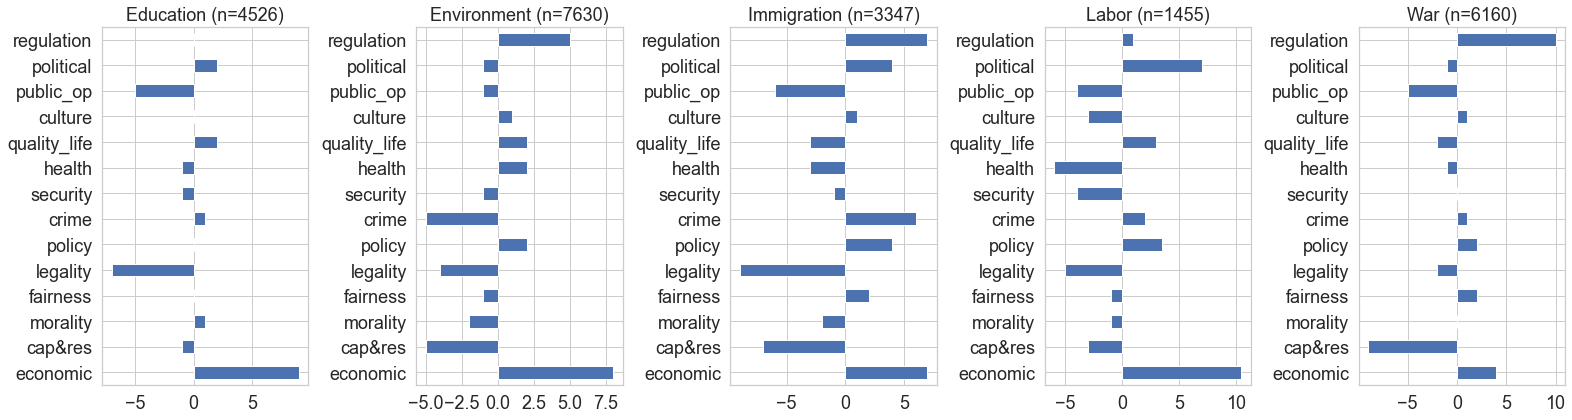

In [164]:
# Rank difference (text-image) plot for selected topics

# Grouped bar plot for each topic
fig, ax = plt.subplots(figsize=(22,6))
plt.xticks([])
plt.yticks([])
i = 1
for group_name, group in selected_topic_df.groupby('gpt_topic'):
    text_frame_counter = {f:0.0 for f in valid_frames}
    vision_frame_counter = {f:0.0 for f in valid_frames}
    for index, row in group.iterrows():
        for frame_pred in row['text-generic-frame']:
            text_frame_counter[frame_pred] += 1/len(group)
        for frame_pred in row['img-generic-frame']:
            vision_frame_counter[frame_pred] += 1/len(group)
    text_frame_counter_df = pd.DataFrame.from_dict(text_frame_counter, orient='index').reset_index()
    text_frame_counter_df.columns = ['Frame', 'Text_Frame_Count']
    vision_frame_counter_df = pd.DataFrame.from_dict(vision_frame_counter, orient='index').reset_index()
    vision_frame_counter_df.columns = ['Frame', 'Image_Frame_Count']
    frame_counter_df = pd.merge(text_frame_counter_df, vision_frame_counter_df, on='Frame', how='outer')
    ax = plt.subplot(1,5,i)
    i+=1
    plt.title(group_name+' (n='+str(len(group))+')', fontsize=18)
    frame_counter_df.set_index('Frame', inplace=True)
    frame_counter_df = frame_counter_df.loc[frame_counter_df.index[:-1]]
    frame_rank = frame_counter_df.rank()
    frame_rank_sub = frame_rank['Text_Frame_Count'] - frame_rank['Image_Frame_Count']
    frame_rank_sub.plot(kind='barh', ax=ax, legend=False, xlabel='', ylabel='', fontsize=18)
plt.tight_layout()
plt.show()